**Import Libraries**


In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from os.path import join, basename
import os.path
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv3D,
    MaxPooling3D,
    UpSampling3D,
    concatenate,
    Activation,
)
import cv2

2024-03-04 15:44:03.363429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 15:44:03.363466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 15:44:03.364753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 15:44:03.372277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 15:44:04.347118: W tensorflow/compiler/tf2

**Define Parameters**


In [2]:
FNAME_PATTERN = "./"
N_VOLUMES = 10
IMAGE_SIZE = (256, 128, 256)

N_CLASSES = 5
N_INPUT_CHANNELS = 1
PATCH_SIZE = (64, 64, 64)
PATCH_STRIDE = (32, 32, 32)

CONTENT_THRESHOLD = 0.3

N_EPOCHS = 50
BATCH_SIZE = 1
PATIENCE = 10
MODEL_FNAME_PATTERN = "unet3d.h5"
OPTIMISER = "Adam"
LOSS = "categorical_crossentropy"

**Model Definition**


In [3]:
def get_unet(
    img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1
):
    inputs = keras.Input(shape=img_size + (n_input_channels,))
    # dropout_rate = 0.2
    # Encoding path
    conv1 = Conv3D(32 * scale, (3, 3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv3D(32 * scale, (3, 3, 3), padding="same", activation="relu")(conv1)
    # drop1 = layers.Dropout(rate=dropout_rate)(conv1, training=True)
    max1 = MaxPooling3D((2, 2, 2))(conv1)

    conv2 = Conv3D(64 * scale, (3, 3, 3), padding="same", activation="relu")(max1)
    conv2 = Conv3D(64 * scale, (3, 3, 3), padding="same", activation="relu")(conv2)
    # drop2 = layers.Dropout(rate=dropout_rate)(conv2, training=True)
    max2 = MaxPooling3D((2, 2, 2))(conv2)

    conv3 = Conv3D(128 * scale, (3, 3, 3), padding="same", activation="relu")(max2)
    conv3 = Conv3D(128 * scale, (3, 3, 3), padding="same", activation="relu")(conv3)
    # drop3 = layers.Dropout(rate=dropout_rate)(conv3, training=True)
    max3 = MaxPooling3D((2, 2, 2))(conv3)

    lat = Conv3D(256 * scale, (3, 3, 3), padding="same", activation="relu")(max3)

    # Decoding path
    up1 = UpSampling3D((2, 2, 2))(lat)
    concat1 = concatenate([conv3, up1], axis=-1)
    conv4 = Conv3D(128 * scale, (3, 3, 3), padding="same", activation="relu")(concat1)
    conv4 = Conv3D(128 * scale, (3, 3, 3), padding="same", activation="relu")(conv4)
    # drop4 = layers.Dropout(rate=dropout_rate)(conv4, training=True)

    up2 = UpSampling3D((2, 2, 2))(conv4)
    concat2 = concatenate([conv2, up2], axis=-1)
    conv5 = Conv3D(64 * scale, (3, 3, 3), padding="same", activation="relu")(concat2)
    conv5 = Conv3D(64 * scale, (3, 3, 3), padding="same", activation="relu")(conv5)
    # drop5 = layers.Dropout(rate=dropout_rate)(conv5, training=True)

    up3 = UpSampling3D((2, 2, 2))(conv5)
    concat3 = concatenate([conv1, up3], axis=-1)
    conv6 = Conv3D(32 * scale, (3, 3, 3), padding="same", activation="relu")(concat3)
    conv6 = Conv3D(32 * scale, (3, 3, 3), padding="same", activation="relu")(conv6)
    # drop6 = layers.Dropout(rate=dropout_rate)(conv6, training=True)

    outputs = Conv3D(n_classes, (1, 1, 1), activation="softmax")(conv6)

    model = Model(inputs, outputs)

    return model

**Load Data**


In [4]:
def load_data(n_volumes, image_size, data_path):
    data_traces = os.listdir(data_path)
    T1_volumes = np.zeros((n_volumes, *image_size, 1))
    labels = np.zeros((n_volumes, *image_size, 1))
    x = 0
    for i in enumerate(data_traces):
        print(i[1])

        img_data = nib.load(
            data_path + "/" + f"{i[1]}" + "/" + f"{i[1]}_5labels_preprocessed.nii.gz"
        )
        # img_data = nib.load(fname_pattern.format(i+1, 'T1'))
        T1_volumes[x] = img_data.get_fdata()

        seg_data = nib.load(
            data_path
            + "/"
            + f"{i[1]}"
            + "/"
            + f"{i[1]}_5labels_preprocessed_seg.nii.gz"
        )
        labels[x] = seg_data.get_fdata()
        x = x + 1

    return (T1_volumes, labels)

In [5]:
(training_volumes_T1, training_labels) = load_data(7, IMAGE_SIZE, "./data/train")

IBSR_16
IBSR_04
IBSR_08
IBSR_03
IBSR_06
IBSR_01
IBSR_07


In [6]:
(validation_volumes_T1, validation_labels) = load_data(3, IMAGE_SIZE, "./data/val")

IBSR_18
IBSR_09
IBSR_05


In [7]:
(testing_volumes_T1, testing_labels) = load_data(5, IMAGE_SIZE, "./data/test")

IBSR_13
IBSR_12
IBSR_14
IBSR_11
IBSR_17


**Extract Useful Patches**


In [8]:
def extract_patches(x, patch_size, patch_stride):
    spatial_patch_size = [1, *patch_size, 1]
    spatial_patch_stride = [1, *patch_stride, 1]

    return tf.extract_volume_patches(
        x,
        ksizes=spatial_patch_size,
        strides=spatial_patch_stride,
        padding="SAME",
        name=None,
    )

In [9]:
def extract_useful_patches(
    volumes,
    labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES,
):
    volumes = volumes.reshape([-1, image_size[0], image_size[1], image_size[2], 1])
    labels = labels.reshape([-1, image_size[0], image_size[1], image_size[2], 1])
    print(volumes.shape)

    vol_patches = extract_patches(volumes, patch_size, stride).numpy()
    seg_patches = extract_patches(labels, patch_size, stride).numpy()

    vol_patches = vol_patches.reshape([-1, *patch_size, 1])
    seg_patches = seg_patches.reshape([-1, *patch_size])
    print(vol_patches.shape)
    print(seg_patches.shape)

    foreground_mask = seg_patches != 0

    useful_patches = foreground_mask.sum(axis=(1, 2, 3)) > threshold * np.prod(
        patch_size
    )

    vol_patches = vol_patches[useful_patches]
    seg_patches = seg_patches[useful_patches]
    print(seg_patches.shape[0])

    seg_patches = tf.keras.utils.to_categorical(
        seg_patches, num_classes=N_CLASSES, dtype="float32"
    )

    return (vol_patches, seg_patches)

In [ ]:
(training_patches_T1, training_patches_seg) = extract_useful_patches(
    training_volumes_T1, training_labels
)
(validation_patches_T1, validation_patches_seg) = extract_useful_patches(
    validation_volumes_T1, validation_labels
)

**Train Network**


In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_FNAME_PATTERN, save_best_only=True
    ),
]

model = get_unet()
model.compile(optimizer=OPTIMISER, loss=LOSS)
model.fit(
    x=training_patches_T1,
    y=training_patches_seg,
    validation_data=(validation_patches_T1, validation_patches_seg),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1,
)

**Load Best Model**


In [10]:
model = get_unet(
    img_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS,
)
model.compile(optimizer=OPTIMISER, loss=LOSS)
model.load_weights("unet3d.h5")

2024-03-04 15:44:27.324989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10065 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


In [11]:
testing_volumes_T1_processed = testing_volumes_T1.reshape(
    [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2], 1]
)
testing_labels_processed = testing_labels.reshape(
    [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2], 1]
)

testing_labels_processed = tf.keras.utils.to_categorical(
    testing_labels_processed, num_classes=5, dtype="float32"
)

**Predict Labels For Test Data**


In [12]:
print(testing_volumes_T1[0].shape)

(256, 128, 256, 1)


In [13]:
prediction = model.predict(x=testing_volumes_T1, batch_size=1)
print(prediction.shape)

# prediction = np.argmax(prediction, axis=3)
# print(prediction.shape)
# plt.imshow(prediction[128, :, :])

2024-03-04 15:44:34.988112: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


5/5 [==============================] - 19s 756ms/step
(5, 256, 128, 256, 5)


In [14]:
pred1 = prediction[0]
pred1 = np.argmax(pred1, axis=3)
pred1.shape

(256, 128, 256)

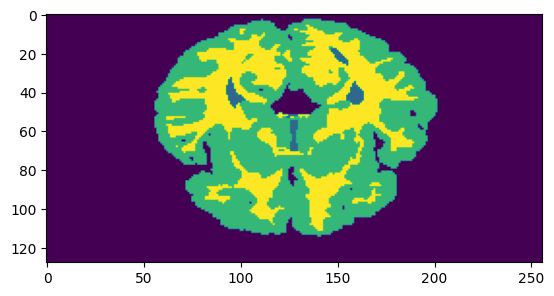

In [15]:
plt.imshow(pred1[128, :, :])

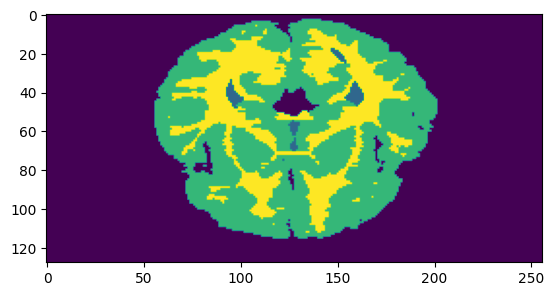

In [16]:
plt.imshow(np.squeeze(testing_labels[0][128, :, :]))

**Dice & IOU Score Evaluation**


In [17]:
def compute_dice_iou(prediction, labels):
    prediction = prediction.squeeze()
    labels = labels.squeeze()
    dice = []
    iou = []
    for c in np.unique(prediction):
        intersection = np.logical_and(prediction == c, labels == c).sum()
        sum = (prediction == c).sum() + (labels == c).sum()
        union = sum - intersection
        dice.append(2 * intersection / sum)
        iou.append(intersection / union)
    return dice, iou

In [18]:
dice_background = []
iou_background = []

dice_csf = []
iou_csf = []

dice_wm = []
iou_wm = []
dice_gm = []
iou_gm = []
dices = []
ious = []

# prediction = model.predict(x=testing_volumes_T1)
for i in range(5):

    pred = prediction[i]
    pred = np.argmax(pred, axis=3)
    dices, ious = compute_dice_iou(pred, testing_labels[i])
    print(dices, ious)
    dice_background.append(dices[0])
    dice_csf.append(dices[1])
    dice_wm.append(dices[2])
    dice_gm.append(dices[3])

    iou_background.append(ious[0])
    iou_csf.append(ious[1])
    iou_wm.append(ious[2])
    iou_gm.append(ious[3])

[0.9966483523068639, 0.8730096409719496, 0.9148197759376522, 0.8839470731868276] [0.9933190966480353, 0.7746380738561586, 0.843011838635471, 0.7920297075075909]
[0.9974544760728526, 0.7445811364967779, 0.9229099846367945, 0.9169036763334972] [0.9949218786251699, 0.5930937937470835, 0.8568550181254628, 0.8465578326677267]
[0.9980758032757482, 0.870507107308981, 0.9450344052467912, 0.932058797253929] [0.9961589973961247, 0.7707061398456398, 0.8957964221267953, 0.872762278351338]
[0.998265764754161, 0.8575719179689333, 0.931154768924891, 0.9288668802796388] [0.996537534238483, 0.7506572461386789, 0.8711782977113343, 0.8671815511802459]
[0.9960109994334543, 0.9038535794269827, 0.9268001644540416, 0.9040972270316667] [0.9920536966753725, 0.8245737635620685, 0.8635858241466834, 0.8249794136233938]


In [19]:
dice_csf

[0.8730096409719496,
 0.7445811364967779,
 0.870507107308981,
 0.8575719179689333,
 0.9038535794269827]

In [20]:
dice_wm

[0.9148197759376522,
 0.9229099846367945,
 0.9450344052467912,
 0.931154768924891,
 0.9268001644540416]

In [21]:
dice_gm

[0.8839470731868276,
 0.9169036763334972,
 0.932058797253929,
 0.9288668802796388,
 0.9040972270316667]

In [22]:
iou_csf

[0.7746380738561586,
 0.5930937937470835,
 0.7707061398456398,
 0.7506572461386789,
 0.8245737635620685]

In [23]:
iou_wm

[0.843011838635471,
 0.8568550181254628,
 0.8957964221267953,
 0.8711782977113343,
 0.8635858241466834]

In [24]:
iou_gm

[0.7920297075075909,
 0.8465578326677267,
 0.872762278351338,
 0.8671815511802459,
 0.8249794136233938]

In [25]:
print(f"Dice Background : {np.average(np.array(dice_background))}")
print(f"Dice CSF : {np.average(np.array(dice_csf))}")
print(f"Dice WM : {np.average(np.array(dice_wm))}")
print(f"Dice GM : {np.average(np.array(dice_gm))}")

Dice Background : 0.997291079168616
Dice CSF : 0.849904676434725
Dice WM : 0.9281438198400341
Dice GM : 0.913174730817112


In [26]:
print(f"IoU Background : {np.average(np.array(iou_background))}")
print(f"IoU CSF : {np.average(np.array(iou_csf))}")
print(f"IoU WM : {np.average(np.array(iou_wm))}")
print(f"IoU GM : {np.average(np.array(iou_gm))}")

IoU Background : 0.994598240716637
IoU CSF : 0.7427338034299259
IoU WM : 0.8660854801491492
IoU GM : 0.8407021566660591
